#Prep

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset")

#{"username":"morrisnkomo","key":"d88691bce75ac6b9138723f07a9f151e"}

Skipping, found downloaded files in "./network-intrusion-dataset" (use force=True to force download)


This notebook focuses on preparing the dataset for machine learning (ML) models by implementing a thorough data cleaning and treatment pipeline.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

from scipy import stats

#Functions

In [ ]:
# 1. identifying numerical and categorical features in a dataset
def get_feature_types(df, target_col='Attack Type'):

    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()

    # Remove target column if present
    if target_col in numeric_features:
        numeric_features.remove(target_col)
    if target_col in categorical_features:
        categorical_features.remove(target_col)

    return numeric_features, categorical_features

    # 2. Correlation analysis
def correlation_analysis(df, numeric_features, threshold=0.85):

    # Calculate correlation matrix
    corr_matrix = df[numeric_features].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidth = 0.5)
    plt.title('Feature Correlation Heatmap')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    # Identify highly correlated features
    threshold = threshold
    high_corr = np.where(np.abs(corr_matrix) > threshold)
    high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                 for x, y in zip(*high_corr) if x != y and x < y]

    return high_corr

In [ ]:
# 3. Variance analysis
def analyze_variance_homogeneity(df, numeric_features, target_col='Attack Type'):


    results_levene = {}

    for feature in numeric_features:
        # Group data by y and filter out groups with zero values
        groups = [group[feature].dropna().values for name, group in df.groupby(target_col)
                  if not group[feature].dropna().empty]

        # Filter out groups that contain only zero values or have zero variance
        groups = [group for group in groups if len(group) > 0 and np.any(group != 0) and np.var(group) > 0]

        # Check if there are at least two groups with valid data
        if len(groups) < 2:
            print(f"Not enough valid groups to perform Levene's test for feature: {feature}")
            continue  # Skip this feature if not enough valid groups

        # Perform Levene's Test
        stat_levene, p_value_levene = stats.levene(*groups)
        results_levene[feature] = {'Statistic': stat_levene, 'p-value': p_value_levene}

    return results_levene

    # 4. Feature importance analysis
def analyze_feature_importance(df, numeric_features, target_col='Attack Type'):

    h_scores = {}

    for feature in numeric_features:
        # Group data by y and perform the Kruskal-Wallis test
        groups = [group[feature].dropna().values for name, group in df.groupby(target_col)]
        h_stat, p_val = stats.kruskal(*groups)
        h_scores[feature] = {'H-statistic': h_stat, 'p-value': p_val}

    # Create a DataFrame from the results
    h_scores_df = pd.DataFrame.from_dict(h_scores, orient='index')
    h_scores_df = h_scores_df.sort_values('H-statistic', ascending=False)

    # Plotting H-statistics
    plt.figure(figsize=(18, 10))
    plt.bar(range(len(h_scores_df)), h_scores_df['H-statistic'], color='skyblue')
    plt.xticks(range(len(h_scores_df)), h_scores_df.index, rotation=90)
    plt.title('Feature Importance based on H-statistic (Kruskal-Wallis Test)')
    plt.xlabel('Features')
    plt.ylabel('H-statistic')
    plt.tight_layout()
    plt.show()

    return h_scores_df

In [ ]:
# 5. Feature importance analysis(df, numeric_features, target_col='Attack Type') – Tree Model -> df with features ordered by importance; confusion matrix; labels; cv_scores
def analyze_feature_importance_rf(df, numeric_features, target_col='Attack Type'):


    # Hyperparameter settings
    hyperparameters = {
        'n_estimators': 150,    # Number of trees
        'max_depth': 30,        # Limit tree depth
        'random_state': 42,     # For reproducibility
        'n_jobs': -1            # Use all available cores
    }

    # Prepare the data
    X = df[numeric_features]
    y = df[target_col]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=hyperparameters['random_state'], stratify=y)

    # Create the Random Forest model with specified hyperparameters
    rf = RandomForestClassifier(**hyperparameters)

    # Fit the model on the training set
    rf.fit(X_train, y_train)

    # Cross-validation on the training set
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, n_jobs=-1)
    print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

    # Predict on test set
    y_pred = rf.predict(X_test)

    # Feature importances
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': numeric_features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    # Confusion matrix
    rf_labels = rf.classes_
    cm = confusion_matrix(y_test, y_pred)

    # Calculate test scores
    report = classification_report(y_test, y_pred, target_names=rf_labels)
    print("\nClassification Report:\n")
    print(report, end='\n\n')

    # Plot feature importances
    plt.figure(figsize=(18, 12))
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Feature Importance from Random Forest')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return feature_importance_df, cm, rf_labels, cv_scores

    # 6. Calculation of the percentage of outliers for each feature (df) – IQR -> dict with outliers percentage
def calculate_outliers_percentage(df):


    outlier_percentages = {}  # empty dictionary to store outlier percentages

    for column in df.columns:
        Q1 = df[column].quantile(0.25)  # first quartile (Q1) for the column
        Q3 = df[column].quantile(0.75)  # third quartile (Q3) for the column
        IQR = Q3 - Q1  # Interquartile Range (IQR)

        lower_bound = Q1 - 1.5 * IQR  # lower bound for outliers
        upper_bound = Q3 + 1.5 * IQR  # upper bound for outliers

        # Identify outliers in the column
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        # Calculate the percentage of outliers for the column
        outlier_percentage = len(outliers) / len(df) * 100

        # Store the outlier percentage in the dictionary
        outlier_percentages[column] = outlier_percentage

    return outlier_percentages

#Data log

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/.config/.last_update_check.json
/content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
/content/.config/default_configs.db
/content/.config/gce
/content/.config/config_sentinel
/content/.config/active_config
/content/.config/.last_opt_in_prompt.yaml
/content/.config/.last_survey_prompt.yaml
/content/.config/configurations/config_default
/content/.config/logs/2025.09.19/13.40.21.959342.log
/content/.config/logs/2025.09.19/13.40.30.940050.log
/content/.config/logs/2025.09.19/13.40.32.438351.log
/content/.config/logs/2025.09.19/13.39.59.525129.log
/content/.config/logs/2025.09.19/13.40.41.341666.log
/content/.config/logs/2025.09.19/13.40.42.120946.log
/content/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv
/content/network-intrusion-dataset/Tuesday-WorkingHours.pcap_ISCX.csv
/content/network-intrusion-dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv
/content/network-intrusion-dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX

In [ ]:

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# List of dataset files to load
dataset_files = [
    "/content/network-intrusion-dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "/content/network-intrusion-dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "/content/network-intrusion-dataset/Tuesday-WorkingHours.pcap_ISCX.csv",
    "/content/network-intrusion-dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    "/content/network-intrusion-dataset/Monday-WorkingHours.pcap_ISCX.csv",
    "/content/network-intrusion-dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "/content/network-intrusion-dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "/content/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv"
]

# Load and concatenate all datasets in one operation. a typical IDS should be able to handle different types of attacks.
# Since the CICIDS2017 dataset is divided into eight files containing various attack data, these files should be merged into a single cohesive unit.
df = pd.concat([pd.read_csv(f) for f in dataset_files])

# Deleting DataFrames after merging
for dfs in dataset_files: del dfs

# Clean column names by stripping whitespace
df.columns = df.columns.str.strip()

# Print dataset dimensions
nRow, nCol = df.shape
print(f'The dataset contains {nRow:,} rows and {nCol} columns')

The dataset contains 2,830,743 rows and 79 columns


#Examining the dataset

In [ ]:
# Display data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  Flow I

In [ ]:
# Check for missing values
missing_values = df.isna().sum()
missing_percentage = (missing_values / len(df)) * 100

for column, count in missing_values.items():
    if count != 0:
        print(f"Column '{column}' has {count} missing values")

Column 'Flow Bytes/s' has 1358 missing values


#First Clean
Removing duplicates and infinite values from a dataset enhances data integrity, improves statistical accuracy, increases efficiency, and simplifies analysis.



In [ ]:
# Remove whitespace
col_names = {col: col.strip() for col in df.columns}
df.rename(columns = col_names, inplace = True)

# Checking for duplicates
duplicates = df.duplicated()
duplicate_count = duplicates.sum()

# Output results
print(f"Number of duplicate rows: {duplicate_count}")

# Removal of duplicates
df = df.drop_duplicates(keep='first')
del duplicates
df.shape

Number of duplicate rows: 308381


(2522362, 79)

In [ ]:
# Identify columns with identical data
identical_columns = {}
columns = df.columns
list_control = columns.copy().tolist()

for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            if df[col1].equals(df[col2]):
                if (col1 not in identical_columns) and (col1 in list_control):
                    identical_columns[col1] = [col2]
                    list_control.remove(col2)
                elif (col1 in identical_columns) and (col1 in list_control):
                    identical_columns[col1].append(col2)
                    list_control.remove(col2)

# Output result
if identical_columns:
    print("Identical columns found:")
    for key, value in identical_columns.items():
        print(f"'{key}' is identical to {value}")
else: print("No identical columns found.")

# Removing the columns with duplicated values
for key, value in identical_columns.items():
    df.drop(columns=value, inplace=True)
df.shape

Identical columns found:
'Total Fwd Packets' is identical to ['Subflow Fwd Packets']
'Total Backward Packets' is identical to ['Subflow Bwd Packets']
'Fwd PSH Flags' is identical to ['SYN Flag Count']
'Bwd PSH Flags' is identical to ['Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
'Fwd URG Flags' is identical to ['CWE Flag Count']
'Fwd Header Length' is identical to ['Fwd Header Length.1']


(2522362, 67)

In [ ]:
# Checking for infinite values
num_columns = df.select_dtypes(include = np.number).columns
has_infinite = np.isinf(df[num_columns]).sum()
print(has_infinite[has_infinite > 0])

df.replace([np.inf, -np.inf], np.nan, inplace=True)

Flow Bytes/s      1211
Flow Packets/s    1564
dtype: int64


In [ ]:
# Attack counts
attack_counts = df['Label'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Number of Occurrences']

# Duplicating the df and dropping rows with missing values
data_no_na = df.dropna()

# Counting the total number of occurrences of each attack after dropping
occurrences_nonull = data_no_na['Label'].value_counts().reset_index()
occurrences_nonull.columns = ['Attack Type', 'Occurrences w/o Null Rows']

# Merging the DataFrames
attack_counts = attack_counts.merge(occurrences_nonull, on='Attack Type', how='left')

# Calculating the difference
attack_counts['Abs Difference'] = attack_counts['Number of Occurrences'] - attack_counts['Occurrences w/o Null Rows']
attack_counts['Difference %'] = ((attack_counts['Abs Difference'] * 100) / attack_counts['Number of Occurrences']).round(2)

# Visualization
attack_counts

Attack Type  Number of Occurrences  \
0                       BENIGN                2096484   
1                     DoS Hulk                 172849   
2                         DDoS                 128016   
3                     PortScan                  90819   
4                DoS GoldenEye                  10286   
5                  FTP-Patator                   5933   
6                DoS slowloris                   5385   
7             DoS Slowhttptest                   5228   
8                  SSH-Patator                   3219   
9                          Bot                   1953   
10    Web Attack � Brute Force                   1470   
11            Web Attack � XSS                    652   
12                Infiltration                     36   
13  Web Attack � Sql Injection                     21   
14                  Heartbleed                     11   

    Occurrences w/o Null Rows  Abs Difference  Difference %  
0                     2095057            1427          0.07  
1                      172846               3          0.00  
2                      128014               2          0.00  
3                       90694             125          0.14  
4                       10286               0          0.00  
5                        5931               2          0.03  
6                        5385               0          0.00  
7                        5228               0          0.00  
8                        3219               0          0.00  
9                        1948               5          0.26  
10                       1470               0          0.00  
11                        652               0          0.00  
12                         36               0          0.00  
13                         21               0          0.00  
14                         11               0          0.00

In [ ]:
# Cleaning up
del data_no_na

# Evaluating percentage of missing values per column
threshold = 10
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Filter columns with missing values over the threshold
high_missing_cols = missing_percentage[missing_percentage > threshold]

In [ ]:
row_missing_percentage = (df.isna().sum(axis=1) / df.shape[1]) * 100
print(row_missing_percentage.describe())

missing_rows = df.isna().any(axis=1).sum()
print(f'\nTotal rows with missing values: {missing_rows}')

df = df.dropna()
print(f'Dataset shape after row-wise removal: {df.shape}')

count    2.522362e+06
mean     1.850907e-03
std      7.430795e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.985075e+00
dtype: float64

Total rows with missing values: 1564
Dataset shape after row-wise removal: (2520798, 67)


#Feature Selection

In [ ]:
# Check for numeric columns that contain only a single unique value for removal, due to lack of diversity.
only_unique_cols = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        only_unique_cols.append(col)
        print(col)

print(f'\nThe number of columns with only one unique values is: {len(only_unique_cols)}')

Bwd PSH Flags

The number of columns with only one unique values is: 1


In [ ]:
# Dropping the columns with only one unique value
df.drop(only_unique_cols, axis=1, inplace=True)
del only_unique_cols
df.shape

(2520798, 66)

#Grouping Attack Types
As seen above, the dataset categorizes various types of attacks into distinct groupss. Given the imbalance present in the dataset, consolidating these classes could enhance the training process of ML models.

In [ ]:
# Mapping the attacks to the new group
group_mapping = {
    'BENIGN': 'Normal Traffic',
    'DoS Hulk': 'DoS',
    'DDoS': 'DDoS',
    'PortScan': 'Port Scanning',
    'DoS GoldenEye': 'DoS',
    'FTP-Patator': 'Brute Force',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bots',
    'Web Attack � Brute Force': 'Web Attacks',
    'Web Attack � XSS': 'Web Attacks',
    'Infiltration': 'Infiltration',
    'Web Attack � Sql Injection': 'Web Attacks',
    'Heartbleed': 'Miscellaneous'
}

# Map to new group column
df['Attack Type'] = df['Label'].map(group_mapping)

# Dropping old Label column
df.drop(columns='Label', inplace=True)

# Given the very low instance counts for 'Infiltration' (36) and 'Heartbleed' (11), it is advisable to  remove these categories
# from the dataset as they can lead to overfitting even techniques like SMOTE may not be sufficient to create a representative training sample.

df.drop(df[(df['Attack Type'] == 'Infiltration') | (df['Attack Type'] == 'Miscellaneous')].index, inplace=True)

# Data shape and attack counts after removal
print(df.shape)
df['Attack Type'].value_counts()


(2520538, 66)


Attack Type
Normal Traffic    2094902
DoS                193723
DDoS               127991
Port Scanning       90682
Brute Force          9150
Web Attacks          2142
Bots                 1948
Name: count, dtype: int64

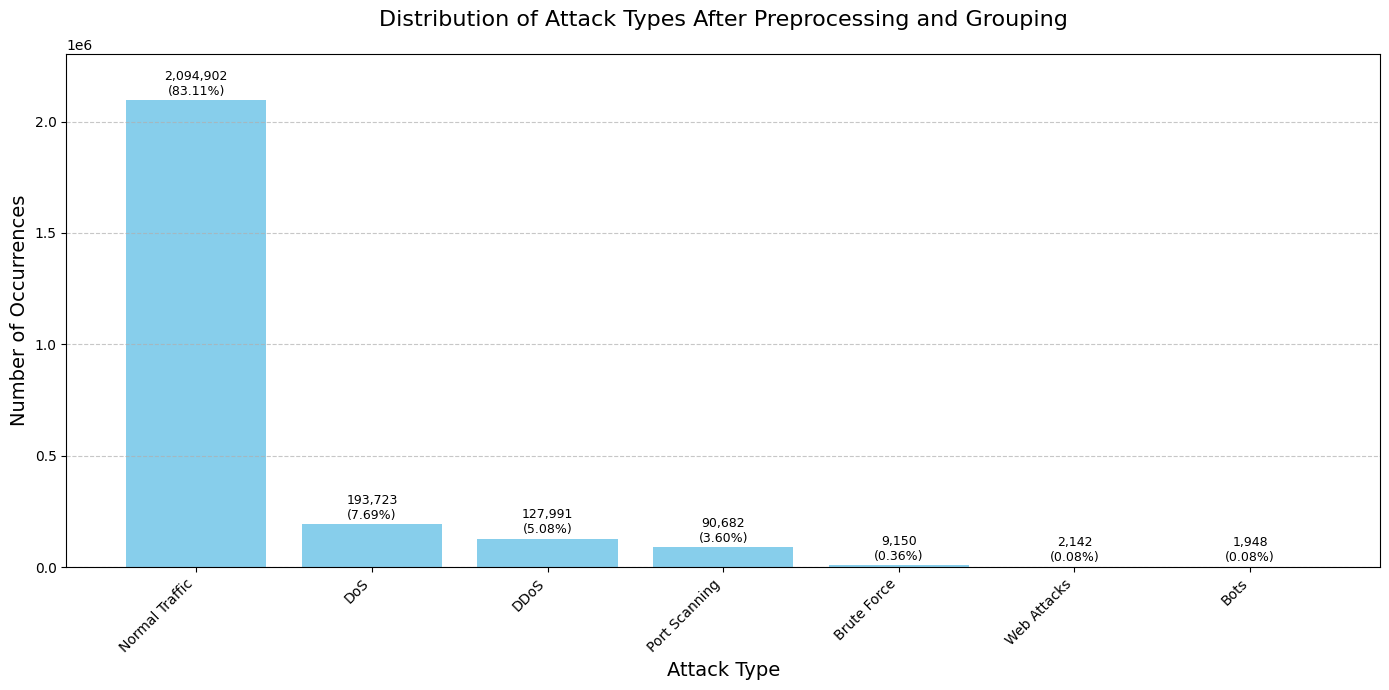

In [ ]:
# Calculate the value counts for the new 'Attack Type' column
attack_counts = df['Attack Type'].value_counts()

# Create the figure and axis
plt.figure(figsize=(14, 7))

# Create the bar plot. 'attack_counts.index' are the class names, 'attack_counts.values' are the counts.
bars = plt.bar(attack_counts.index, attack_counts.values, color='skyblue')

# Customize the chart
plt.title('Distribution of Attack Types After Preprocessing and Grouping', fontsize=16, pad=20)
plt.xlabel('Attack Type', fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability

# (Optional) Annotate the bars with the exact count and percentage
for bar in bars:
    height = bar.get_height()
    percentage = (height / len(df)) * 100
    # Format the text: count with commas and percentage with 2 decimal places
    text_label = f'{height:,}\n({percentage:.2f}%)'
    plt.text(bar.get_x() + bar.get_width()/2., height + 10000, text_label,
             ha='center', va='bottom', fontsize=9)

# Adjust y-axis limit to make room for the labels
plt.ylim(0, max(attack_counts.values) * 1.1)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() # Ensures labels fit in the figure
plt.show()

# Exploratory Data Analysis (EDA)


##Correlation Analysis
This provides valuable insights that could inform further data engineering efforts, such as considering the application of Principal Component Analysis (PCA) to reduce dimensionality and enhance model performance.

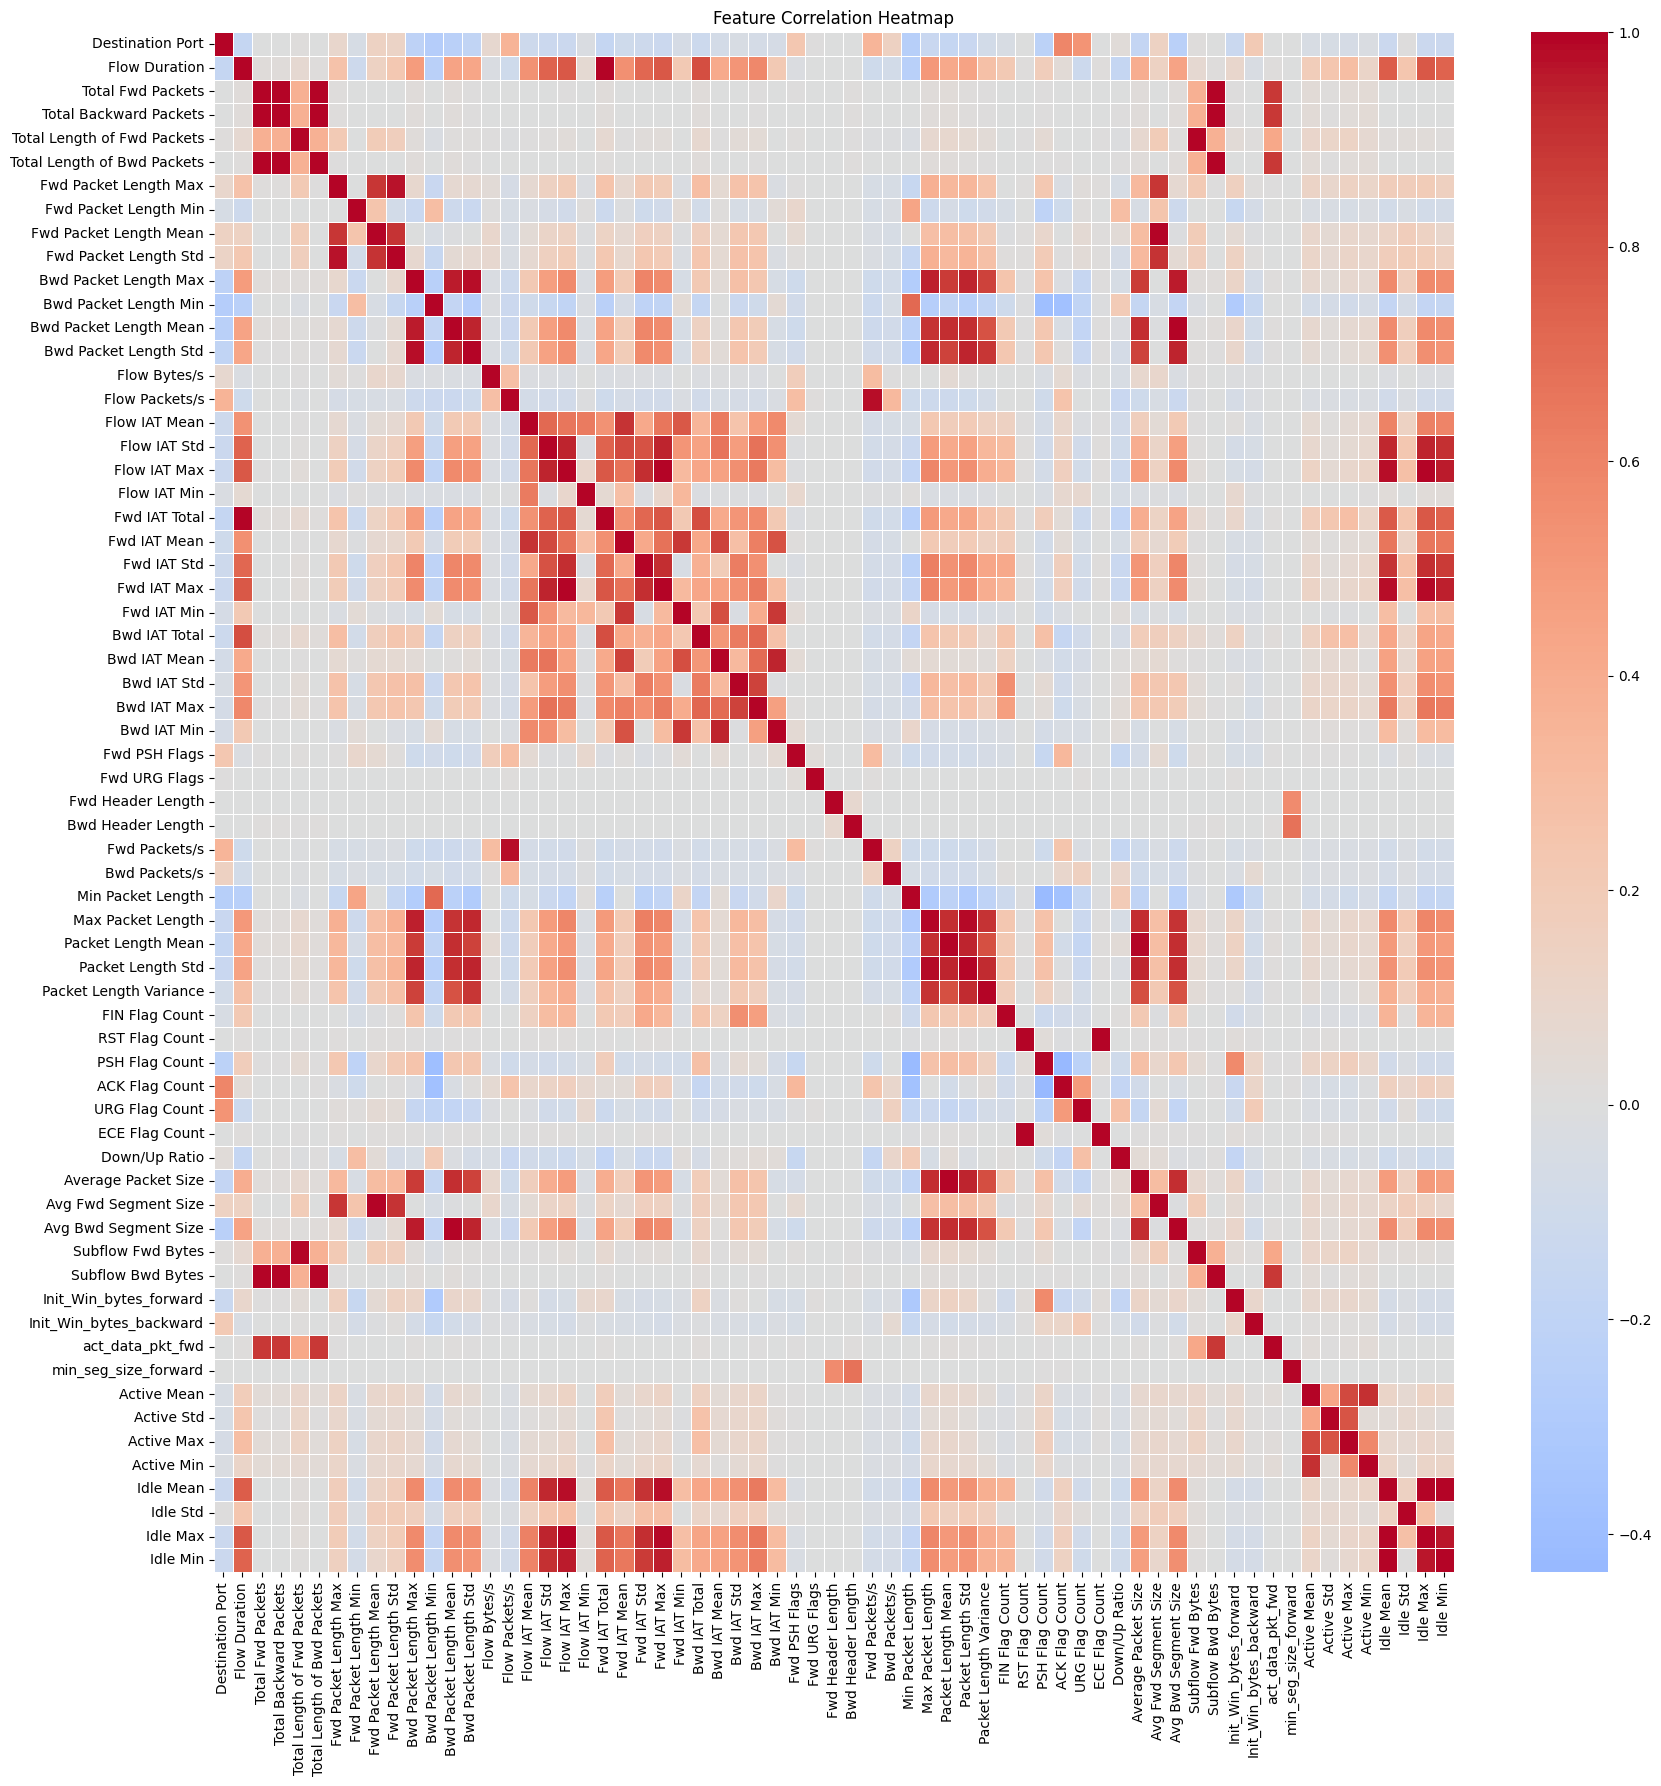

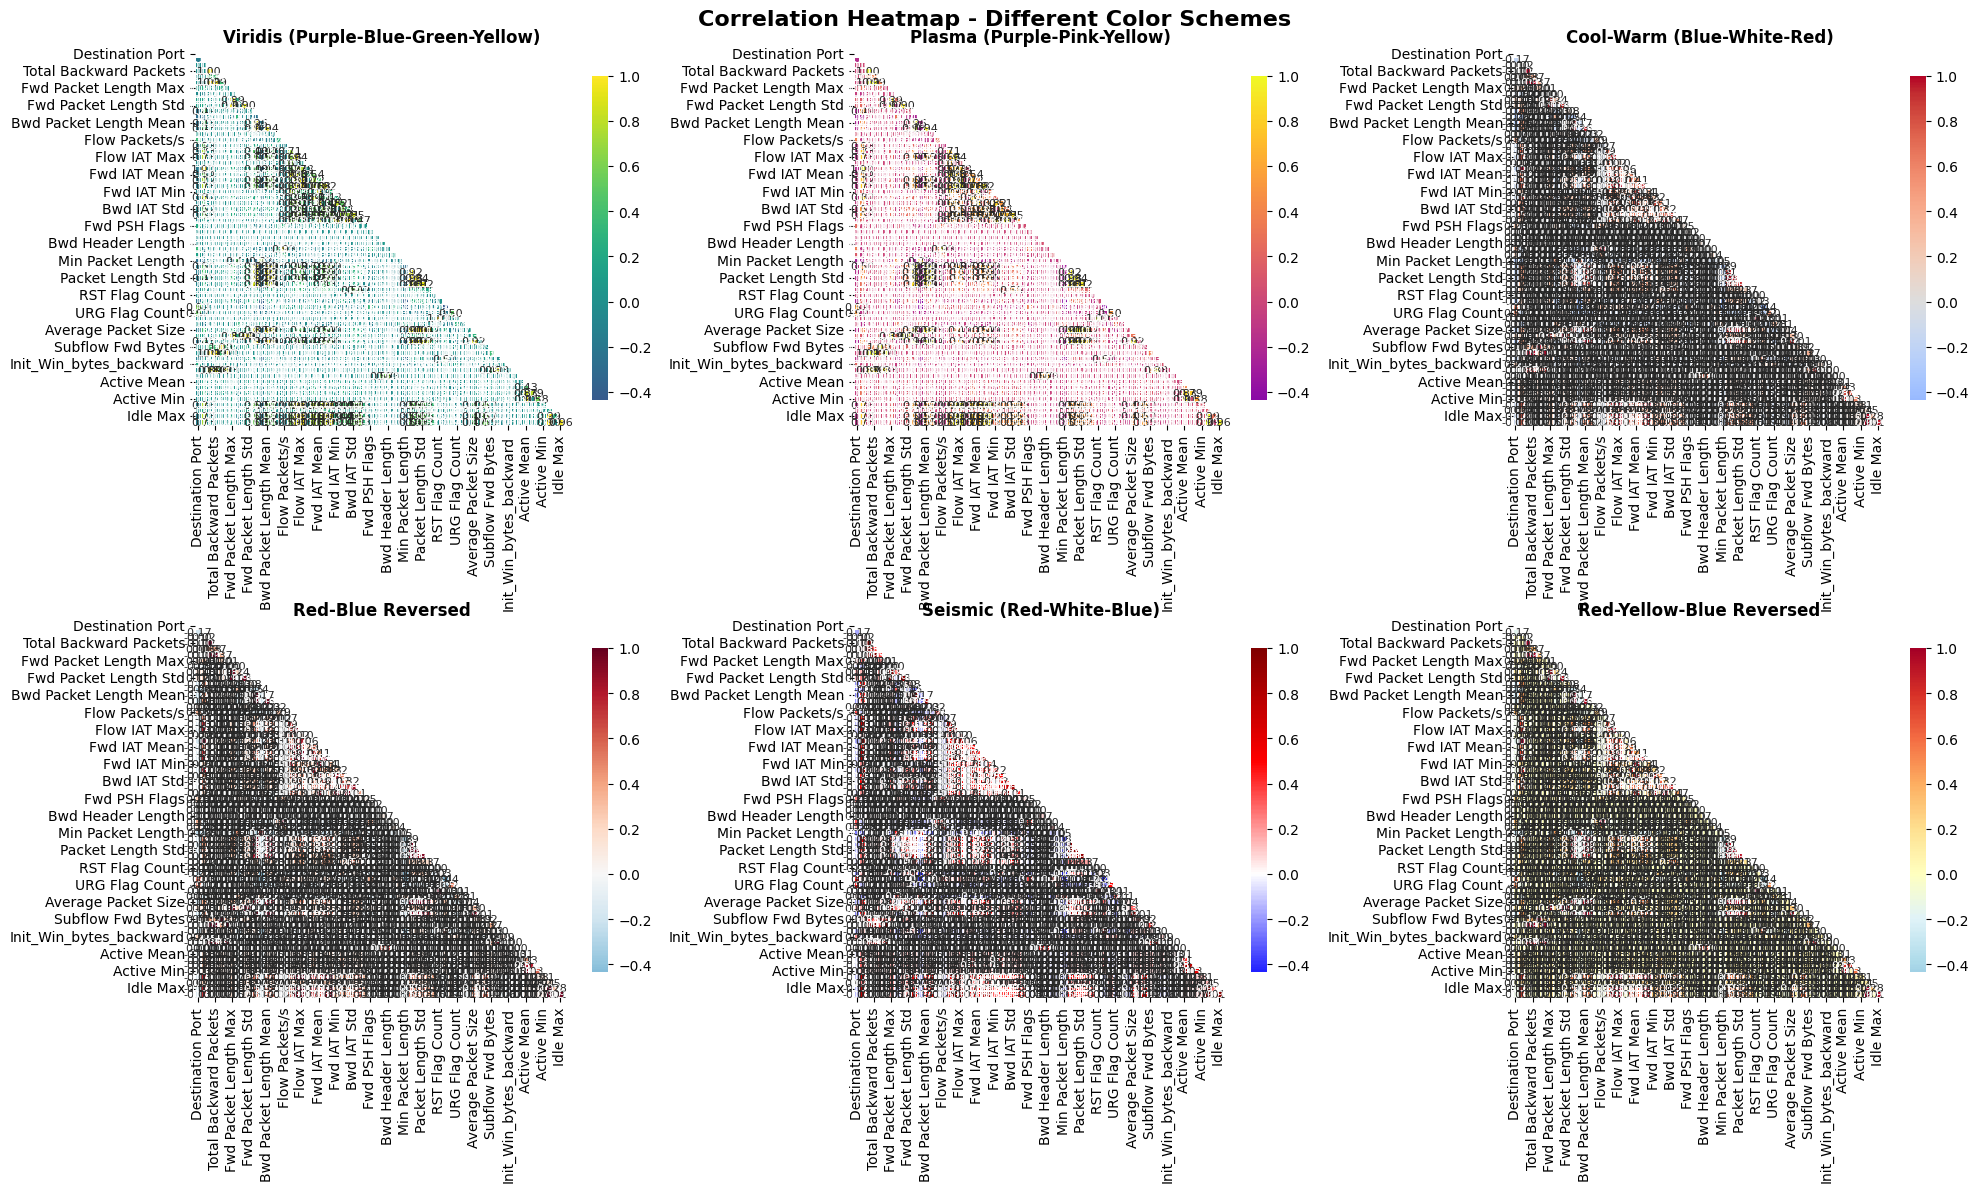

Choose your preferred color scheme from above and update this section:


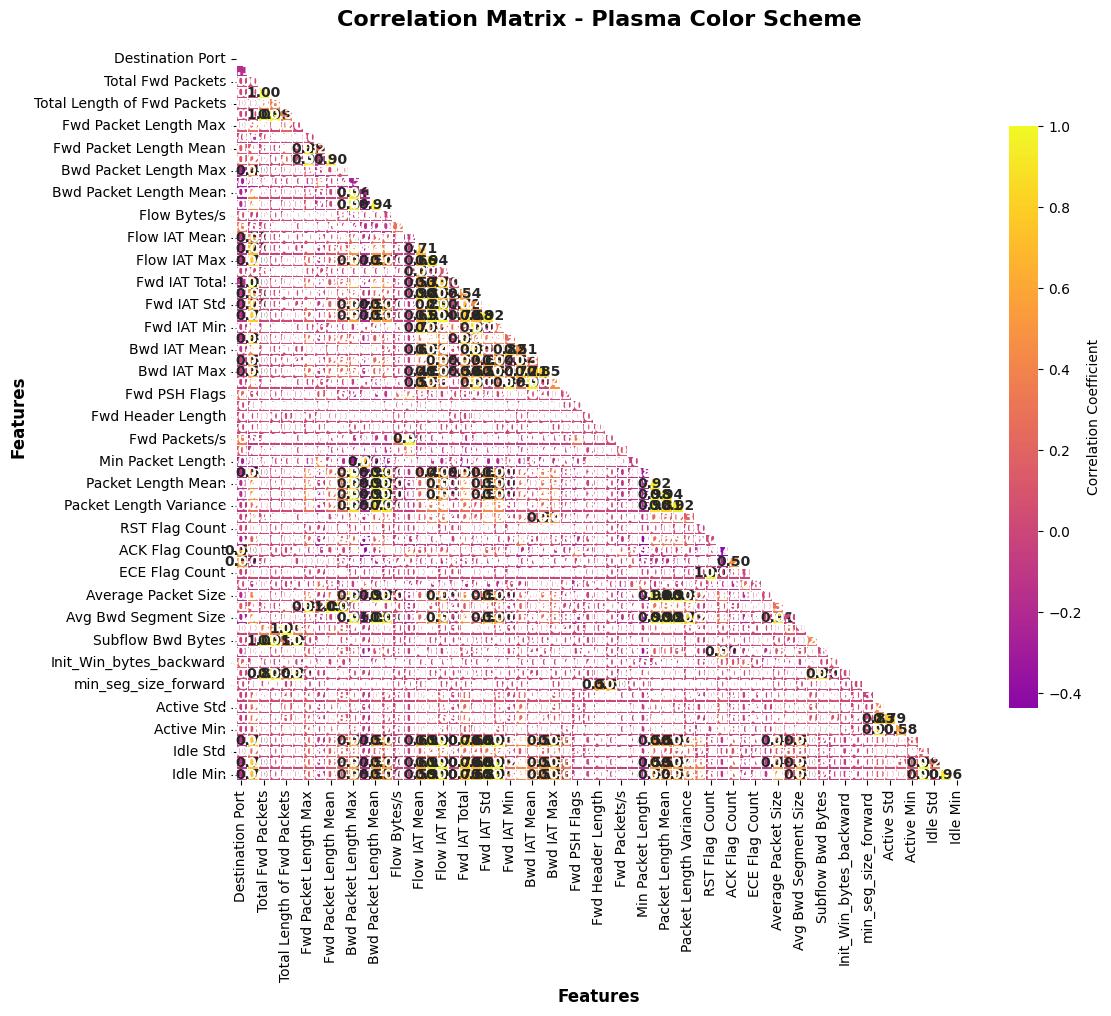


Custom Color Options:


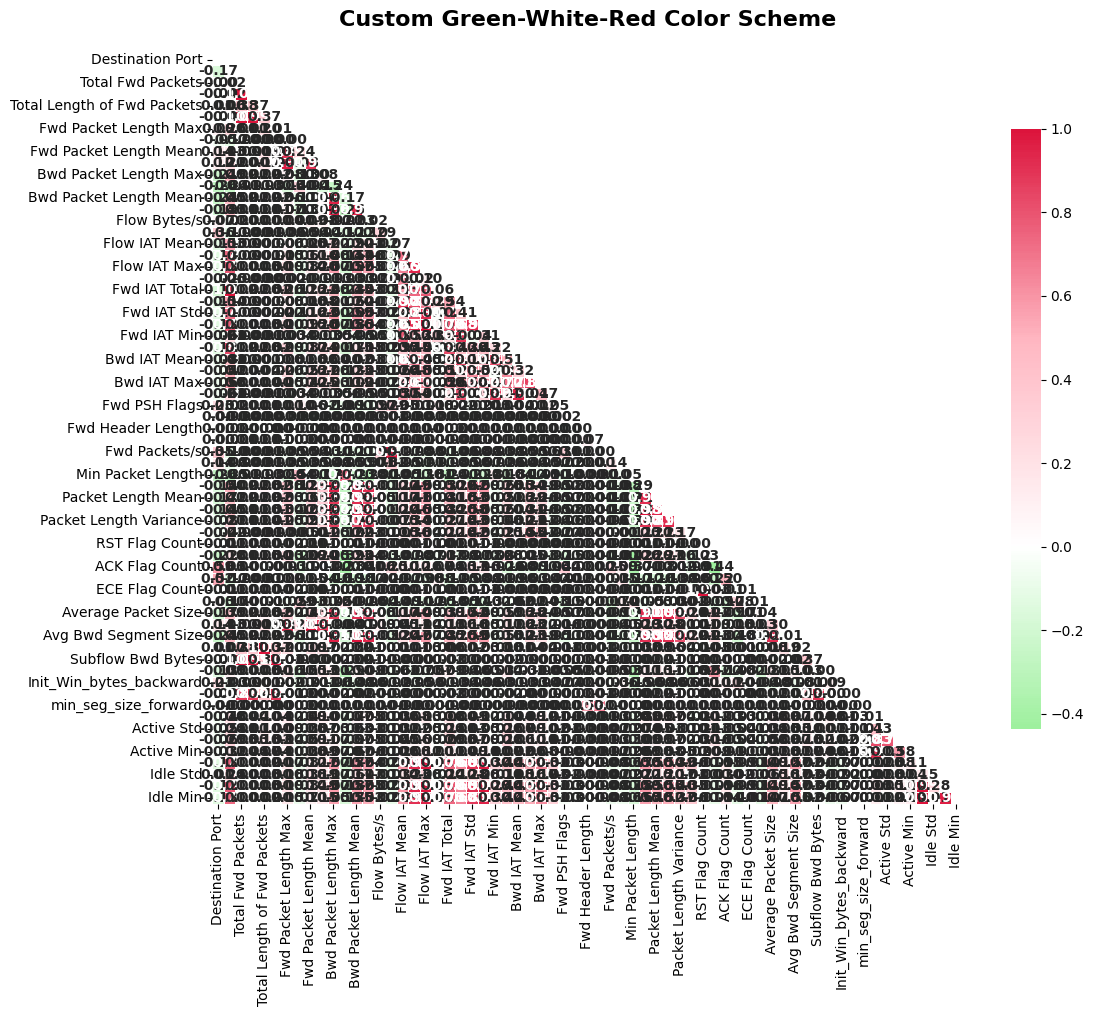

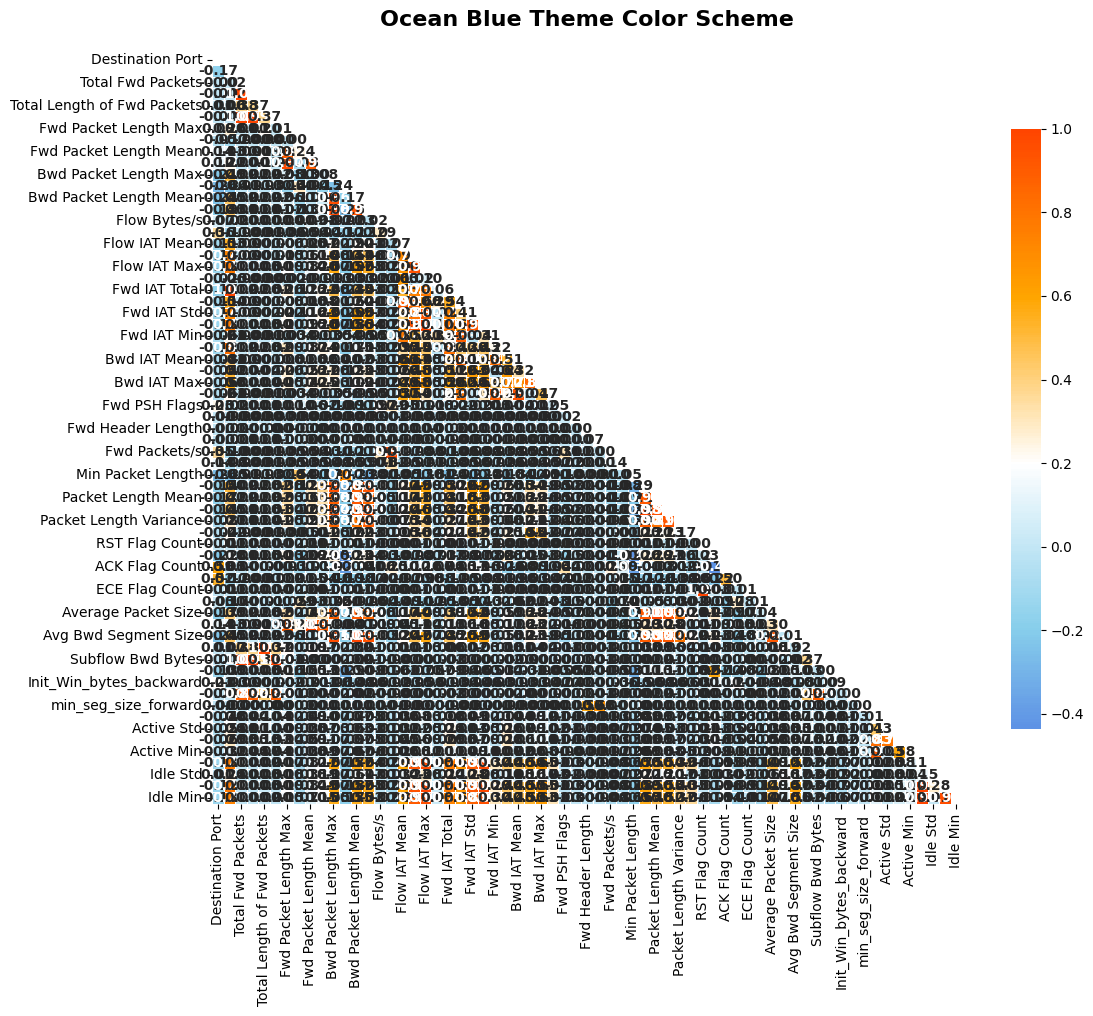

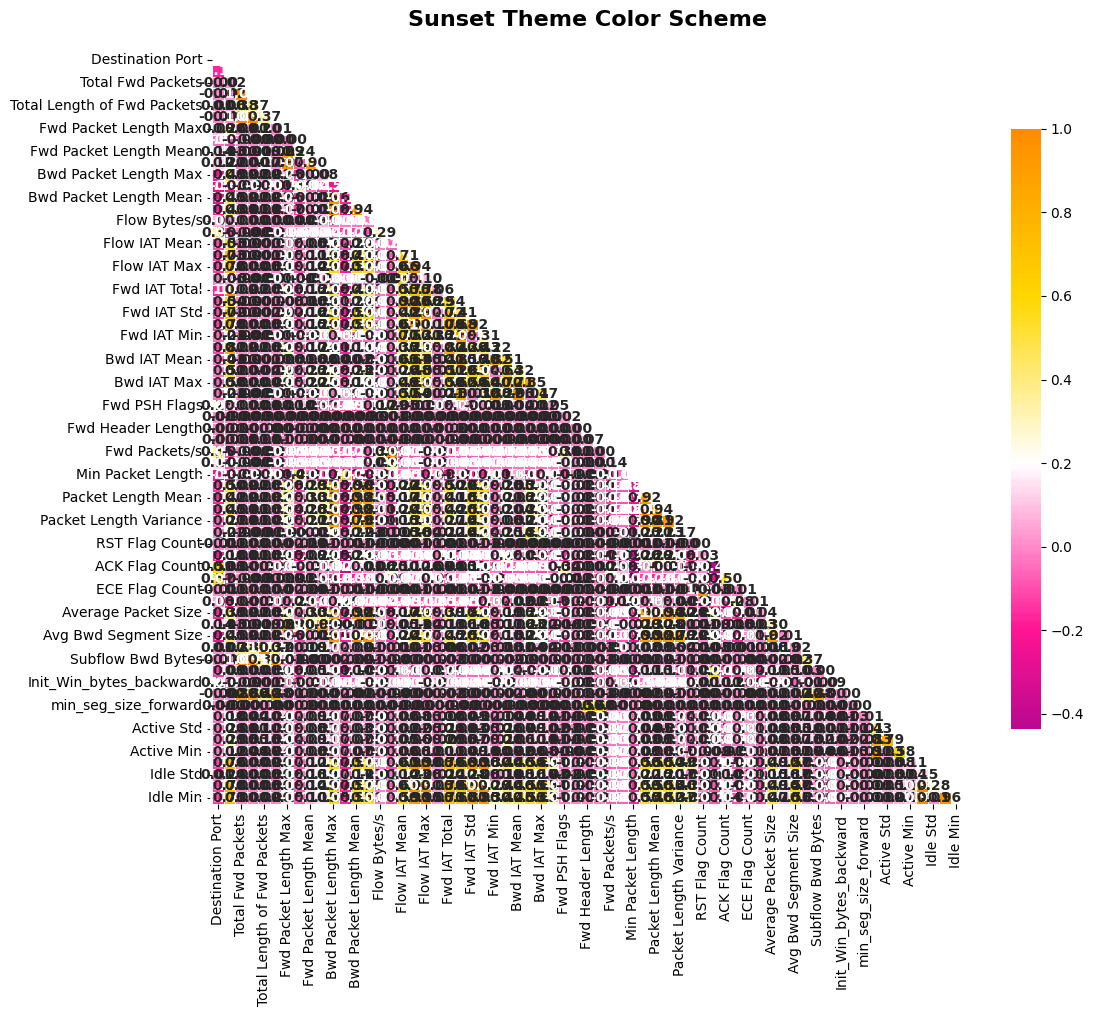

COLOR SCHEME GUIDE:
Built-in Options:
• viridis: Purple → Blue → Green → Yellow
• plasma: Purple → Pink → Yellow
• coolwarm: Blue → White → Red (most popular)
• RdBu_r: Red → White → Blue
• seismic: Red → White → Blue (high contrast)
• RdYlBu_r: Red → Yellow → Blue

Custom Themes:
• Green-Red: Nature-inspired
• Ocean Blue: Professional blue theme
• Sunset: Vibrant purple-pink-gold

To use your preferred color:
1. Look at the comparison above
2. Change PREFERRED_COLORMAP variable
3. Run the single heatmap section


In [ ]:
# Correlation Analysis:
numeric_features, categorical_features = get_feature_types(df)
high_corr = correlation_analysis(df, numeric_features)

In [ ]:
# Collecting pairs with high correlation and isolating the near/perfect multicollinearity
high_multicollinearity = []
for item in high_corr:
    if item[2] >= 0.95:
        high_multicollinearity.append(item)

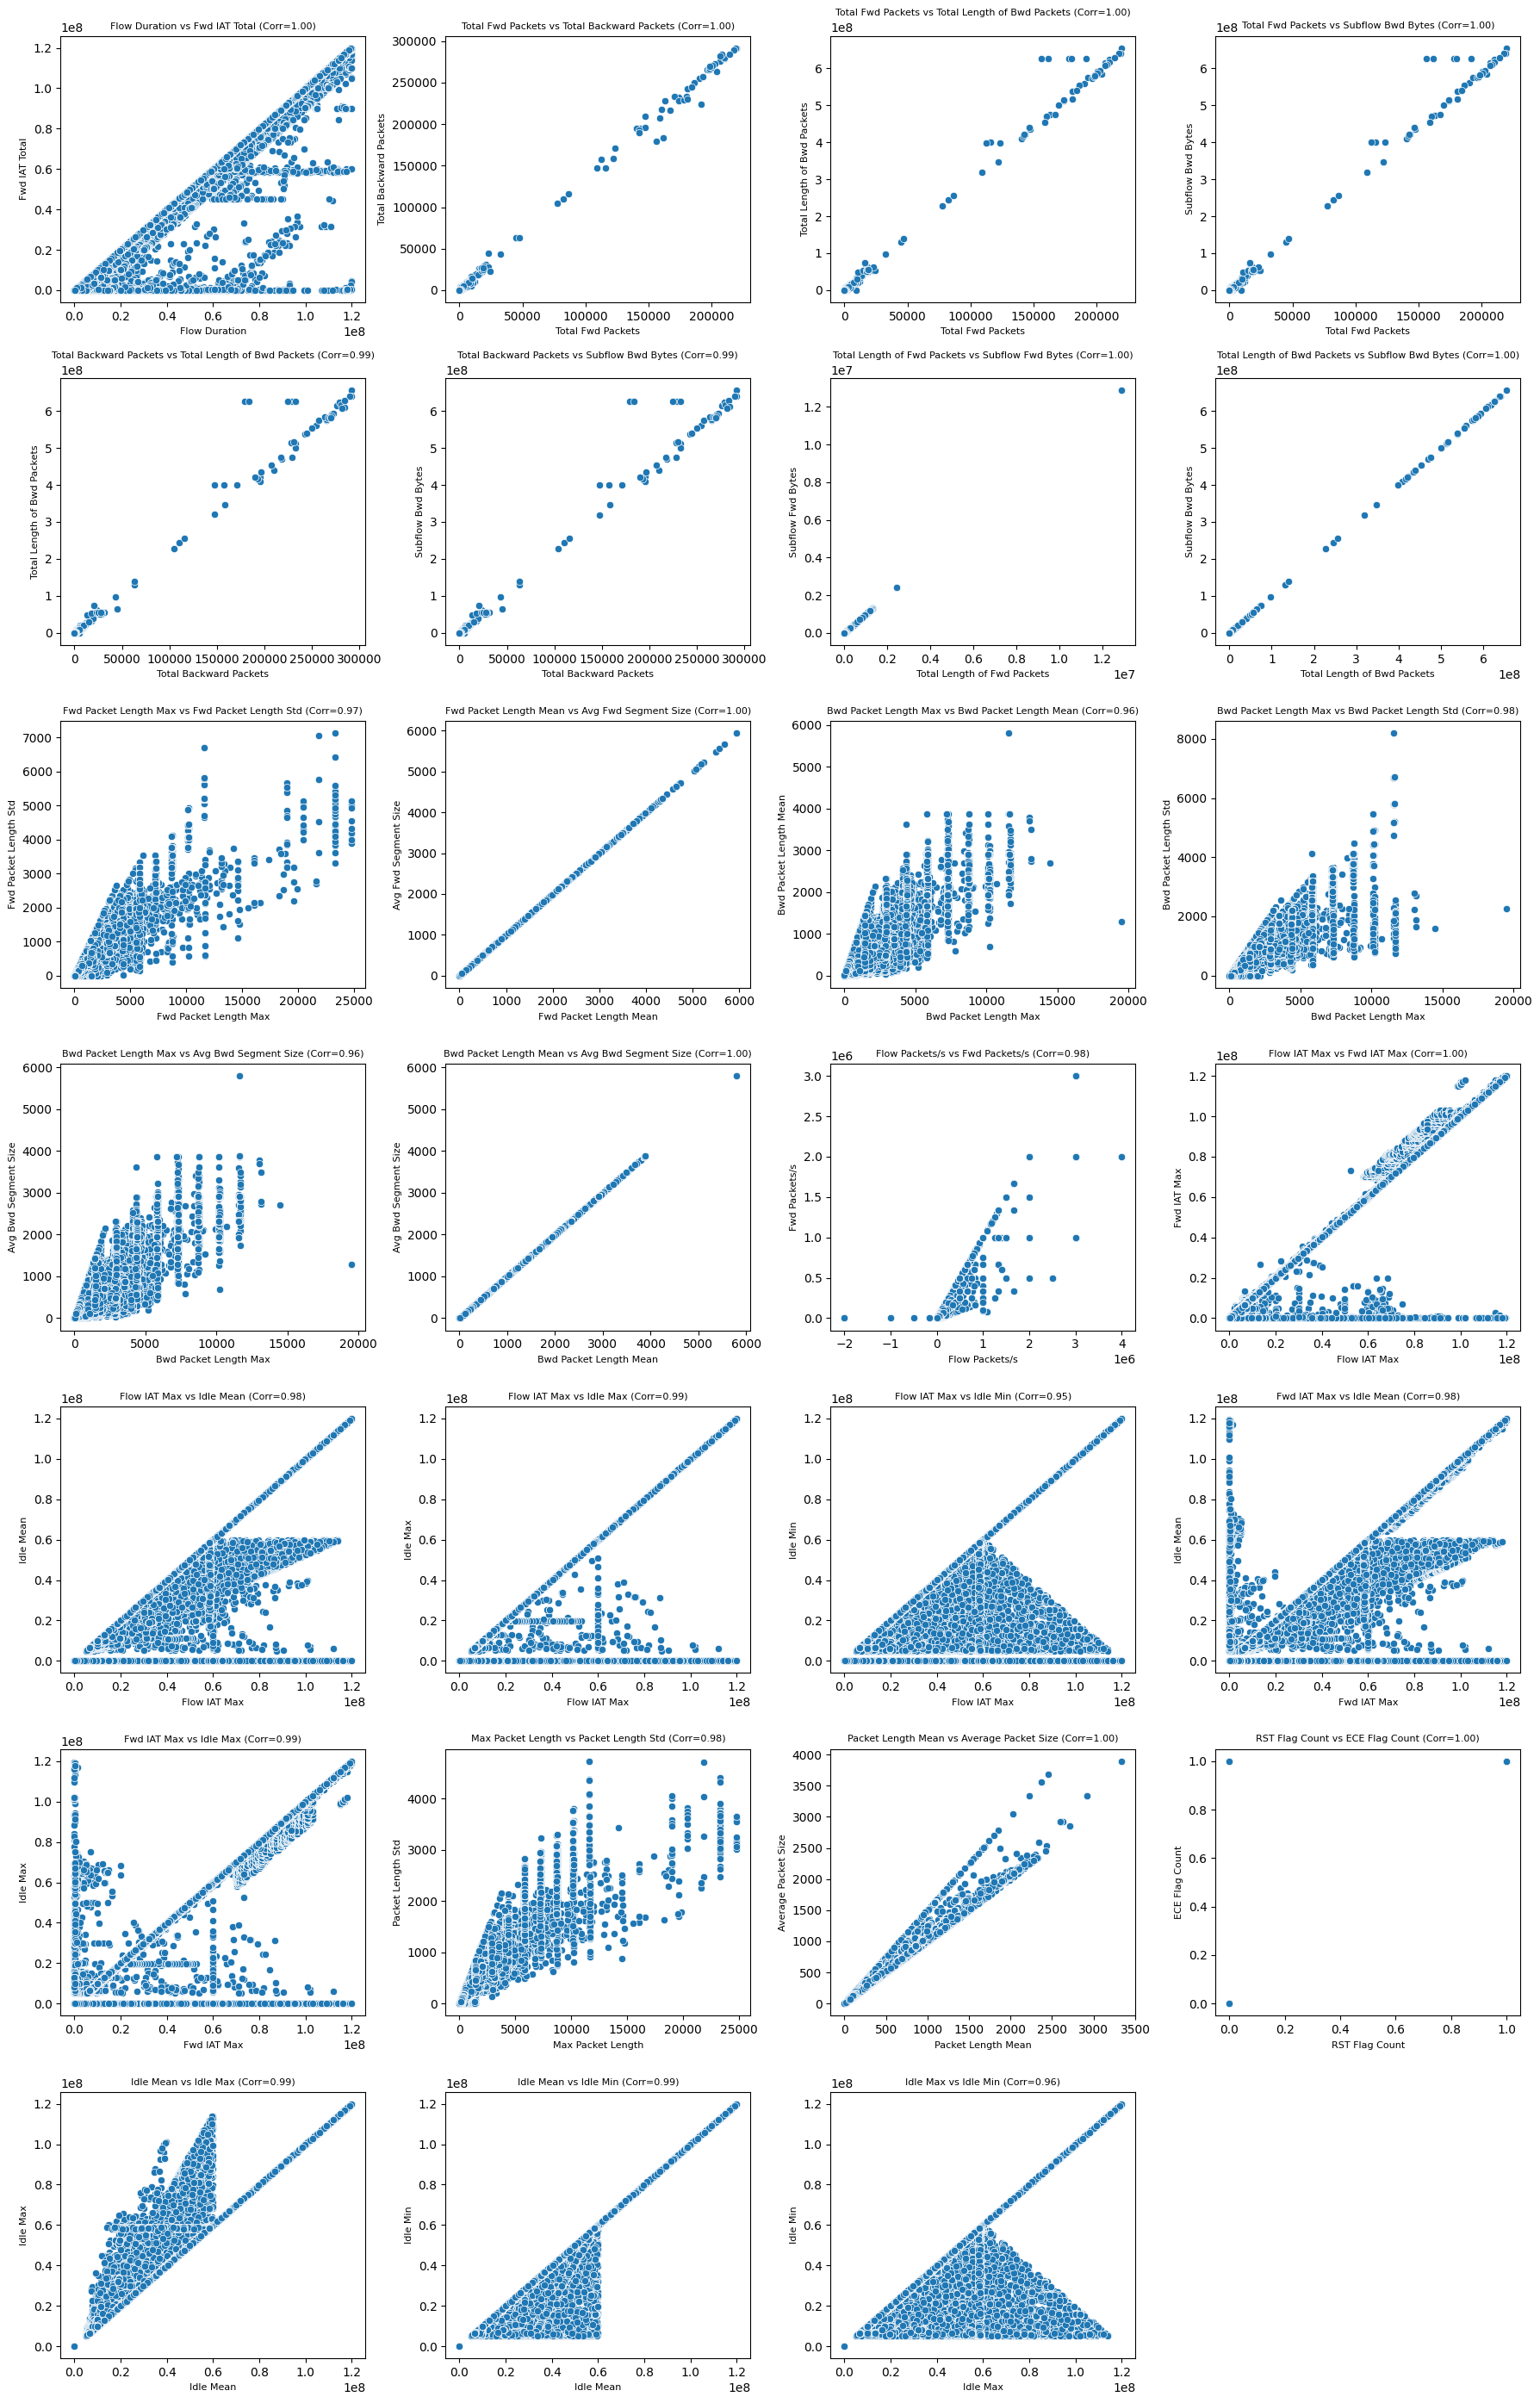

In [ ]:
# Plotting the pairs with very high correlation for better visualization

n_plots = len(high_multicollinearity)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, item in enumerate(high_multicollinearity):
    feature_x = item[0]
    feature_y = item[1]
    corr_value = item[2]

    # Scatter plot
    sns.scatterplot(x=df[feature_x], y=df[feature_y], ax=axes[i])
    axes[i].set_title(f'{feature_x} vs {feature_y} (Corr={corr_value:.2f})', fontsize=8)
    axes[i].set_xlabel(feature_x, fontsize=8)
    axes[i].set_ylabel(feature_y, fontsize=8)

# Hide any unused subplots
for j in range(len(high_multicollinearity), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# Removal of columns based on correlation analysis
selected_columns = ['Total Backward Packets', 'Total Length of Bwd Packets', 'Subflow Bwd Bytes', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

# dropping columns with perfect/near perfect multicollinearity
df.drop(columns=selected_columns, inplace=True)

numeric_features, categorical_features = get_feature_types(df)
df.shape

(2520538, 61)

##Outliers
Outlier detection plays a crucial role in ensuring the quality and reliability of a dataset. Identifying features with significant deviations from the norm can help improve model accuracy by preventing skewed results.



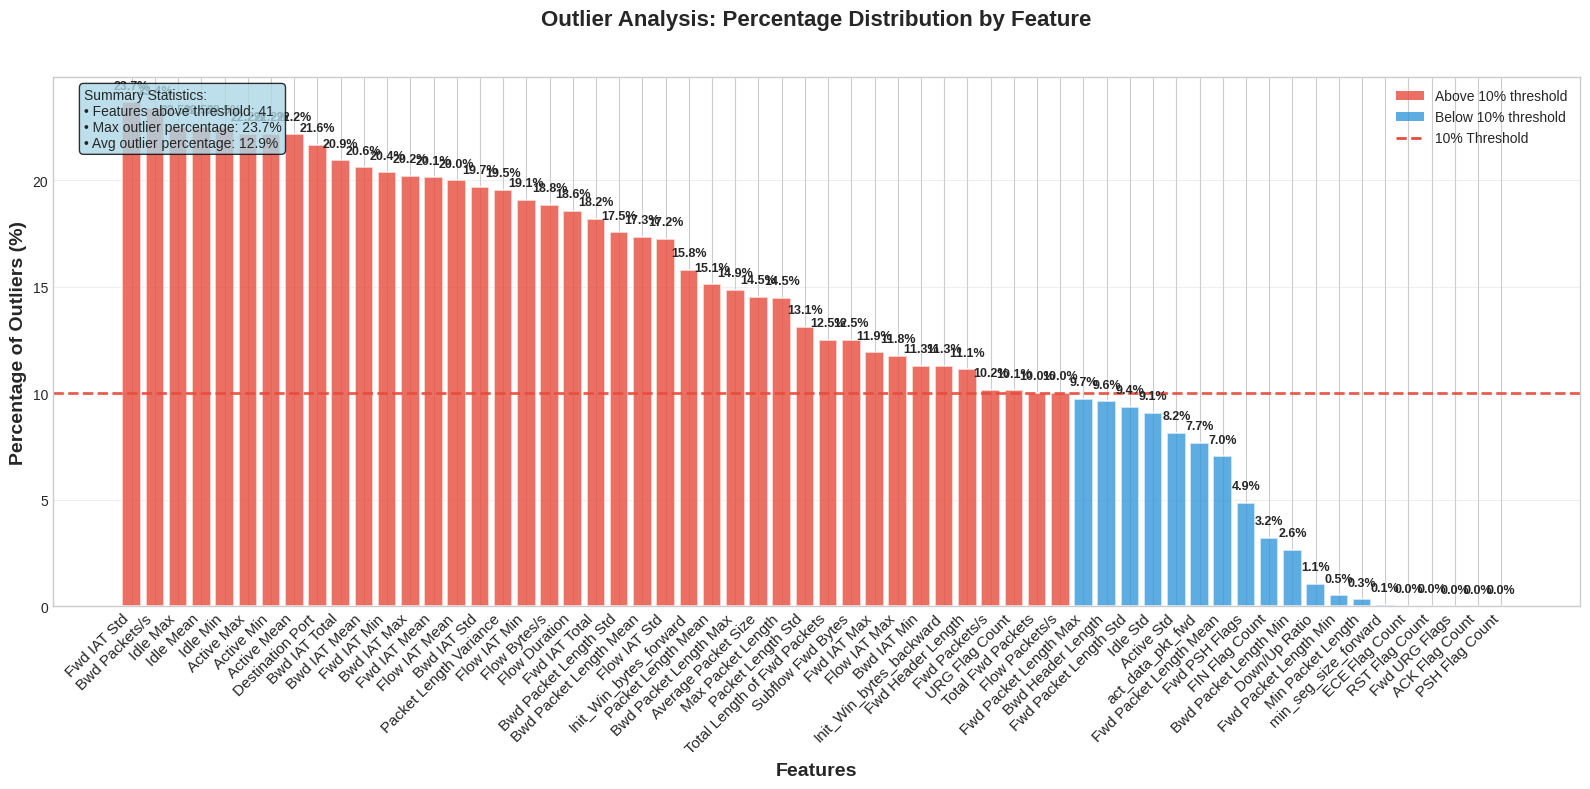

OUTLIER ANALYSIS SUMMARY
Total features analyzed: 60
Features above 10% threshold: 41

Features with highest outlier percentages:
----------------------------------------
Fwd IAT Std                 23.7% ⚠️ HIGH
Bwd Packets/s               23.4% ⚠️ HIGH
Idle Max                    22.5% ⚠️ HIGH
Idle Mean                   22.5% ⚠️ HIGH
Idle Min                    22.5% ⚠️ HIGH

🚨 Features requiring attention (>10% outliers):
--------------------------------------------------
• Destination Port: 21.6%
• Flow Duration: 18.6%
• Total Fwd Packets: 10.0%
• Total Length of Fwd Packets: 12.5%
• Bwd Packet Length Max: 14.9%
• Bwd Packet Length Mean: 17.3%
• Bwd Packet Length Std: 17.5%
• Flow Bytes/s: 18.8%
• Flow Packets/s: 10.0%
• Flow IAT Mean: 20.0%
• Flow IAT Std: 17.2%
• Flow IAT Max: 11.8%
• Flow IAT Min: 19.1%
• Fwd IAT Total: 18.2%
• Fwd IAT Mean: 20.1%
• Fwd IAT Std: 23.7%
• Fwd IAT Max: 11.9%
• Fwd IAT Min: 20.4%
• Bwd IAT Total: 20.9%
• Bwd IAT Mean: 20.6%
• Bwd IAT Std: 19.7%
• B

In [ ]:
# Calculate outliers percentage
outlier_percentages = calculate_outliers_percentage(df[numeric_features])

# Convert to DataFrame for easier manipulation
outliers_df = pd.DataFrame.from_dict(outlier_percentages, orient='index', columns=['Outlier_Percentage'])

# Define the threshold for concern
threshold = 10

# Identify features with high percentage of outliers
high_outlier_features = outliers_df[outliers_df['Outlier_Percentage'] > threshold]

# Sort data for better visualization
sorted_outliers = outliers_df.sort_values(by='Outlier_Percentage', ascending=False)

# Create enhanced visualization
plt.style.use('seaborn-v0_8-whitegrid')  # Use a clean style
fig, ax = plt.subplots(figsize=(16, 8))

# Create color array - red for above threshold, blue for below
colors = ['#e74c3c' if x > threshold else '#3498db' for x in sorted_outliers['Outlier_Percentage']]

# Create the bar plot
bars = ax.bar(range(len(sorted_outliers)),
              sorted_outliers['Outlier_Percentage'],
              color=colors,
              alpha=0.8,
              edgecolor='white',
              linewidth=1.2)

# Add threshold line
ax.axhline(y=threshold, color='#e74c3c', linestyle='--', linewidth=2,
           label=f'{threshold}% Threshold', alpha=0.9)

# Customize the plot
ax.set_xlabel('Features', fontsize=14, fontweight='bold')
ax.set_ylabel('Percentage of Outliers (%)', fontsize=14, fontweight='bold')
ax.set_title('Outlier Analysis: Percentage Distribution by Feature\n',
             fontsize=16, fontweight='bold', pad=20)

# Set x-axis labels
ax.set_xticks(range(len(sorted_outliers)))
ax.set_xticklabels(sorted_outliers.index, rotation=45, ha='right', fontsize=11)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Customize grid
ax.grid(True, alpha=0.3, axis='y')
ax.set_axisbelow(True)

# Add legend with custom styling
legend_elements = [
    plt.Rectangle((0,0),1,1, facecolor='#e74c3c', alpha=0.8, label=f'Above {threshold}% threshold'),
    plt.Rectangle((0,0),1,1, facecolor='#3498db', alpha=0.8, label=f'Below {threshold}% threshold'),
    plt.Line2D([0], [0], color='#e74c3c', linestyle='--', linewidth=2, label=f'{threshold}% Threshold')
]
ax.legend(handles=legend_elements, loc='upper right', framealpha=0.9)

# Improve layout
plt.tight_layout()

# Add summary text box
summary_text = f"""Summary Statistics:
• Features above threshold: {len(high_outlier_features)}
• Max outlier percentage: {sorted_outliers['Outlier_Percentage'].max():.1f}%
• Avg outlier percentage: {sorted_outliers['Outlier_Percentage'].mean():.1f}%"""

props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
ax.text(0.02, 0.98, summary_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.show()

# Print detailed summary
print("=" * 60)
print("OUTLIER ANALYSIS SUMMARY")
print("=" * 60)
print(f"Total features analyzed: {len(outliers_df)}")
print(f"Features above {threshold}% threshold: {len(high_outlier_features)}")
print("\nFeatures with highest outlier percentages:")
print("-" * 40)
for feature, percentage in sorted_outliers.head(5).iterrows():
    status = "⚠️ HIGH" if percentage[0] > threshold else "✅ Normal"
    print(f"{feature:<25} {percentage[0]:>6.1f}% {status}")

if len(high_outlier_features) > 0:
    print(f"\n🚨 Features requiring attention (>{threshold}% outliers):")
    print("-" * 50)
    for feature, percentage in high_outlier_features.iterrows():
        print(f"• {feature}: {percentage[0]:.1f}%")
else:
    print(f"\n✅ All features are within acceptable outlier range (<{threshold}%)")

In [ ]:
# Cleaning up
del outliers_df
df.shape

(2520538, 61)

##Data Distribution
Understanding the distribution of the data is fundamental for selecting the right preprocessing and modeling techniques. Data distribution also gives insights towards the best statistic tests to perform.

In [ ]:
norm_dist = 0
not_norm_dist = 0

for col in numeric_features:

    # Perform Anderson-Darling test for normality
    result = stats.anderson(df[col], dist='norm')

    # Compare the statistic with the critical value at 5% significance level
    if result.statistic < result.critical_values[2]:  # 5% significance level
        norm_dist += 1
    else:
        not_norm_dist += 1

print(f'{norm_dist} features are normally distributed')
print(f'{not_norm_dist} features are not normally distributed - Reject null hypothesis')

0 features are normally distributed
60 features are not normally distributed - Reject null hypothesis


##Class Imbalance

In [ ]:
# Count occurrences of each attack type and convert to a DataFrame
attack_counts_df = df['Attack Type'].value_counts().reset_index()
attack_counts_df.columns = ['Attack Type', 'Number of Occurrences']

# Counting the total for each attack on both cases
total_occurrences = attack_counts_df['Number of Occurrences'].sum()

# Calculating the respective percentages
attack_counts_df['% of Total'] = ((attack_counts_df['Number of Occurrences'] / total_occurrences) * 100).round(2)

print(attack_counts_df)



      Attack Type  Number of Occurrences  % of Total
0  Normal Traffic                2094902       83.11
1             DoS                 193723        7.69
2            DDoS                 127991        5.08
3   Port Scanning                  90682        3.60
4     Brute Force                   9150        0.36
5     Web Attacks                   2142        0.08
6            Bots                   1948        0.08


Class Imbalance

The previous analysis show a clear class imbalance, which should be taken into consideration while working with the CIC-IDS-2017, as highlighted by Panigrahi and Borah (2018).

Observations:

Dominance of the 'BENIGN' class/ Normal Traffic – 83.1% of the entire dataset
Higher types with lower counts – Even DoS, the second most relevant class, shows low counts
Rare classes even after regrouping, such as Bots, Web Attacks and Brute Force
Potential implications:

Model Bias: Models can become biased towards the majority class, leading to high accuracy but poor recall and precision for minority classes.
Performance Metrics: In an imbalanced dataset, accuracy is often not a sufficient metric to evaluate model performance. F1-score, precision, recall, or ROC-AUC are better suited for assessing the model's ability to classify different classes effectively.
Ideas to address the issue during ML training:

Class weights to penalize mistakes on minority classes
Ensemble Methods can improve overall predictions (Random Forests, XGBoost)
Cross-validation with representative folds
Partial SMOTE to help balancing the distribution
Undersampling the majority class

In [ ]:
# Cleaning up
del attack_counts_df
df.shape

(2520538, 61)

#5. Feature Importance
Before conducting an analysis of feature importance, some characteristics of the dataset must be gathered. We already know it does not follow a Gaussian distribution and has a high presence of outliers. The next step is to evaluate its variance to determine the best statistical test.


In [ ]:
# Applying the Levene's Test
# p-value < 0.05 suggests unequal variances among groups (rejecting the null hypothesis of equal variances)
variance_result = analyze_variance_homogeneity(df, numeric_features)

Not enough valid groups to perform Levene's test for feature: Fwd URG Flags
Not enough valid groups to perform Levene's test for feature: RST Flag Count
Not enough valid groups to perform Levene's test for feature: ECE Flag Count


In [ ]:
# Analysing the results
no_significant_results = True

for feature, result in variance_result.items():
    if result['p-value'] > 0.05:
        print(f"\nFeature: {feature}")
        print(f"  - Test Statistic: {result['Statistic']:.4f}")
        print(f"  - p-value: {result['p-value']:.4f}")
        print("  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).")
        no_significant_results = False

# If no features had p-values > 0.05
if no_significant_results:
    print("\nNo features have p-values greater than 0.05. All features have significant differences in variance.")


Feature: Fwd Header Length
  - Test Statistic: 0.1504
  - p-value: 0.9890
  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).

Feature: Bwd Header Length
  - Test Statistic: 0.3304
  - p-value: 0.9213
  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).

Feature: min_seg_size_forward
  - Test Statistic: 0.6496
  - p-value: 0.6271
  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).


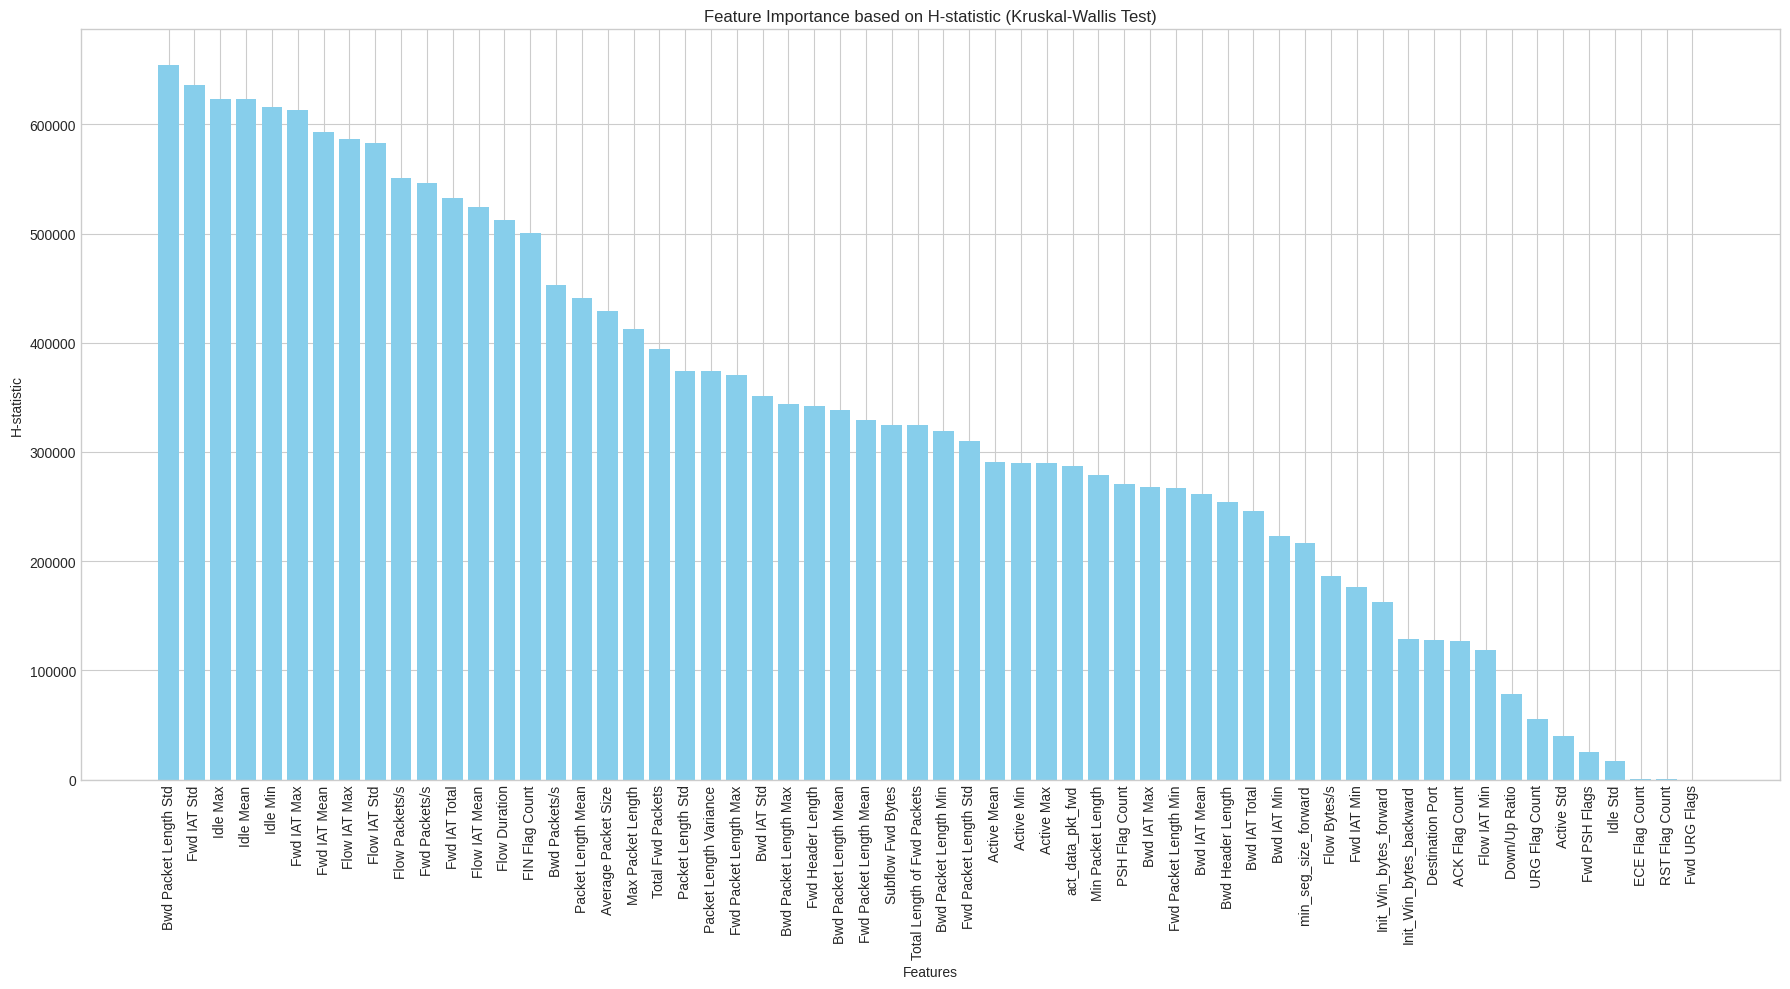

In [ ]:
# Analysing feature importance using Kruskal-Wallis.
h_p_stats = analyze_feature_importance(df, numeric_features)

Now that we have the results from the Kruskal-Wallis test, we will train a Random Forest model and analyze its feature importance scores. This will provide an additional perspective on feature relevance, which we can then compare to the rankings obtained from the Kruskal-Wallis test.

In [ ]:
# Analysing feature importance using Tree-Model
feature_importance_tree, cm, rf_labels, cv_scores = analyze_feature_importance_rf(df, numeric_features)

Random Forests, being ensemble methods, offer a built-in mechanism for assessing feature importance. This importance is calculated based on how much each feature contributes to decreasing impurity (e.g., Gini impurity or entropy) within the decision trees of the forest. Features used higher up in the trees or in more trees of the forest for making splits are considered more important as they contribute more significantly to the model's predictive performance.

In [ ]:
# Evaluating RF performance based on selected features
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8)) # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=rf_labels, yticklabels=rf_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

After evaluating the Random Forest model's performance, we observe an overall positive result, indicating its suitability for feature importance analysis. However, the confusion matrix and the classification report reveal a notable weakness in classifying Bot attacks, with roughly 1/4 of these instances being misclassified as normal traffic (which is not surprising, considering this is a minority class). This misclassification highlights a potential area for improvement in our final intrusion detection model, which could be explored by considering more sophisticated bot detection methods, specialized feature engineering, and data balancing techniques. Despite this limitation, the overall performance justifies using the Random Forest's feature importance scores as a valuable reference for comparison with the Kruskal-Wallis H-statistic in our subsequent feature selection process.

In [ ]:
# Preparing the df for comparison
h_p_stats.reset_index(inplace = True)
h_p_stats.rename(columns = {'index':'Feature'}, inplace = True)

# Sorting the new df for easier visualization
comparison_tb = feature_importance_tree.merge(h_p_stats, on = 'Feature', how = 'left')
comparison_tb_sorted = comparison_tb.sort_values(by='Importance', ascending=False)
comparison_tb_sorted

NameError: name 'h_p_stats' is not defined

In [ ]:
# Create figure and axis
plt.figure(figsize=(25, 10))

# Create a color map based on p-value
colors = sns.color_palette("coolwarm", as_cmap=True)

# Create twin axes for different scales
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot bars for importance
bars = ax1.bar(comparison_tb_sorted['Feature'],
                comparison_tb_sorted['Importance'],
                alpha=0.6,
                color=[colors(0 + (value)) for value in comparison_tb_sorted['p-value']], edgecolor='black')

# Plot line for H-statistic
line = ax2.plot(comparison_tb_sorted['Feature'],
                 comparison_tb_sorted['H-statistic'],
                 color='black',
                 linewidth=2,
                 label='H-statistic',
                 marker='o')

# Add a horizontal threshold line
threshold = 100000
ax2.axhline(y=threshold, color='red', linestyle='--', label=f'H-statistic Threshold ({threshold})')
ax2.legend()

# Customize primary y-axis (Importance)
ax1.set_ylabel('Feature Importance', fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Set x-ticks and labels
ax1.set_xticks(range(len(comparison_tb_sorted['Feature'])))
ax1.set_xticklabels(comparison_tb_sorted['Feature'], rotation=90, ha='center', fontsize=10)

# Add title
plt.title('Feature Importance from Random Forest with H-statistics and p-values',
          fontsize=14, pad=20)

# Add colorbar for p-values
sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=comparison_tb_sorted['p-value'].min(), vmax=0.1))
cbar = plt.colorbar(sm, ax=ax1, orientation='vertical')
cbar.set_label('p-value', fontsize=10)

# Add gridlines for readability
ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

plt.show()

The plot illustrates that while some features selected by the Random Forest (RF) have lower H-statistics, the most significant features are found within the range where the highest H-statistic values are concentrated. The most interesting information, however, lies on the right tail, where there is a convergence on the lowest priority and near-zero H-statistic relevance. Based on these results, the least important features will be removed from the dataset, which helps with:

Improving Model Efficiency: Training with fewer features reduces computational cost (time and memory).
Reducing Noise: Removing irrelevant features can sometimes improve model performance by reducing noise and preventing overfitting.
Simplifying Interpretation: Models with fewer features are often easier to interpret and explain.

In [ ]:
# Removing statiscally irrelavant features from the dataset
cols_to_remove = ['ECE Flag Count', 'RST Flag Count', 'Fwd URG Flags', 'Idle Std', 'Fwd PSH Flags', 'Active Std', 'Down/Up Ratio', 'URG Flag Count']
df.drop(columns=cols_to_remove, inplace=True)

In [ ]:
df.to_csv('cicids2017_cleaned.csv', index=False)
